# Machine Learning Exercise 10

# AlexNet - ARGOS


##Import 

Import libraries and print some versions.

To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

In [ ]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Tensorflow version 1.15.0
Found GPU at: /device:GPU:0


## Load data

Get data from  https://drive.google.com/drive/folders/0Bxxqx_AAp2u2Zkp4cGxoNVEzb3M

Place data in a Google folder and set the datadir variable below with the path of this folder.

Get Google Drive access

Load training data

4774 images from 20 classes



In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

datadir = '/content/drive/My Drive/Data/ARGOS_public'
trainingset = datadir+'/train/'
testset = datadir + '/test/'

batch_size = 32
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4774 images belonging to 20 classes.
Found 1686 images belonging to 20 classes.
Image input (118, 224, 3)
Classes: ['Acqua', 'Alilaguna', 'Ambulanza', 'Barchino', 'Cacciapesca', 'Caorlina', 'Gondola', 'Lancia', 'Motobarca', 'Motopontonerettangolare', 'MotoscafoACTV', 'Mototopo', 'Patanella', 'Polizia', 'Raccoltarifiuti', 'Sandoloaremi', 'Sanpierota', 'Topa', 'VaporettoACTV', 'VigilidelFuoco']
Loaded 4774 training samples from 20 classes.
Loaded 1686 test samples from 20 classes.


##Show *n* random images


VaporettoACTV


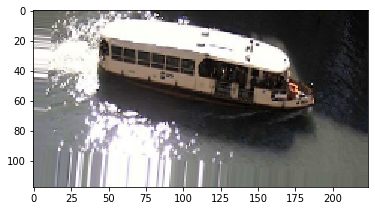

Mototopo


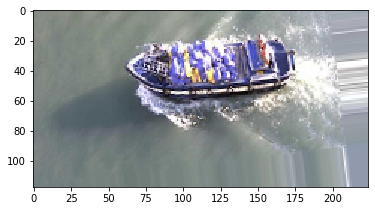

Mototopo


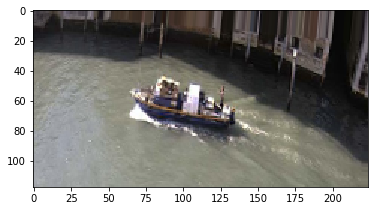

In [ ]:
import matplotlib.pyplot as plt

n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()
    
    


##AlexNet

Create a new model.

Note: if you want to load a pre-trained model on this dataset, go to next section.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

def AlexNet(input_shape, num_classes, regl2 = 0.0001, lr=0.0001):

    model = Sequential()

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=96, input_shape=input_shape, kernel_size=(11,11),\
                     strides=(2,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    # D1 Dense Layer
    model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(4096, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1000,kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    adam = optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model
 
# create the model
model = AlexNet(input_shape,num_classes)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_10 (Activation)   (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_11 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 256)        

###Load a trained model

Load a model already trained on this data set (i.e., saved with save function show in the next section).

In [ ]:
import os
from keras.models import load_model

models_dir = datadir + '/models/'

def loadmodel(problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

model = loadmodel('ARGOS-sc5-2013_20classes_alexnet')


Model loaded successfully from file /content/drive/My Drive/Data/ARGOS/models/ARGOS-sc5-2013_20classes_alexnet.h5



## Train

With GPU, training for 100 epochs takes about 8,500 s., i.e. 2 hours and 22 minutes, including model building and other initialization of the data generator happening in the first epoch.

In [ ]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

try:
    history = model.fit_generator(train_generator, epochs=100, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass


Epoch 1/100
149/149 [==============================] - 1778s 12s/step - loss: 2.4880 - acc: 0.5289 - val_loss: 3.0858 - val_acc: 0.5240
Epoch 2/100
149/149 [==============================] - 69s 463ms/step - loss: 2.0219 - acc: 0.6350 - val_loss: 4.3529 - val_acc: 0.4236
Epoch 3/100
149/149 [==============================] - 70s 467ms/step - loss: 1.8332 - acc: 0.6684 - val_loss: 1.9130 - val_acc: 0.6418
Epoch 4/100
149/149 [==============================] - 69s 464ms/step - loss: 1.7044 - acc: 0.7008 - val_loss: 2.3947 - val_acc: 0.5570
Epoch 5/100
149/149 [==============================] - 70s 467ms/step - loss: 1.6646 - acc: 0.7112 - val_loss: 3.1713 - val_acc: 0.4976
Epoch 6/100
149/149 [==============================] - 69s 464ms/step - loss: 1.6038 - acc: 0.7178 - val_loss: 1.4473 - val_acc: 0.7673
Epoch 7/100
149/149 [==============================] - 69s 466ms/step - loss: 1.5836 - acc: 0.7284 - val_loss: 1.4542 - val_acc: 0.7539
Epoch 8/100
149/149 [===========================

##Save the model

In [ ]:
import os

models_dir = datadir + '/models/'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
savemodel(model,'ARGOS-sc5-2013_20classes_alexnet_100_epochs')


Model saved successfully on file /content/drive/My Drive/Dati/ARGOS/models/ARGOS-sc5-2013_20classes_alexnet_100_epochs.h5



##Evaluate the model

Accuracy on test set

In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate_generator(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)



Found 1686 images belonging to 20 classes.
53/53 [==============================] - 930s 18s/step
Test loss: 0.686637
Test accuracy: 0.906287


Precision, recall, F-score

In [ ]:

import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))


  

Found 1686 images belonging to 20 classes.
53/53 [==============================] - 11s 206ms/step
                         precision    recall  f1-score   support

                  Acqua      0.974     0.879     0.924       420
              Alilaguna      0.487     1.000     0.655        19
              Ambulanza      0.842     0.727     0.780        22
               Barchino      0.250     0.059     0.095        51
            Cacciapesca      0.500     1.000     0.667         1
               Caorlina      0.000     0.000     0.000         1
                Gondola      0.000     0.000     0.000         3
                 Lancia      0.711     0.924     0.804       355
              Motobarca      0.446     0.492     0.468        59
Motopontonerettangolare      1.000     1.000     1.000         3
          MotoscafoACTV      0.333     1.000     0.500         1
               Mototopo      0.886     0.820     0.852       284
              Patanella      0.606     0.581     0.593 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix analysis

In [ ]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(118, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))
  

Found 1686 images belonging to 20 classes.
53/53 [==============================] - 10s 194ms/step
Test set with 1686 images
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
Barchino         ->  Lancia            	32 	1.90 % 
Mototopo         ->  Motobarca         	31 	1.84 % 
Acqua            ->  Lancia            	30 	1.78 % 
Patanella        ->  Lancia            	25 	1.48 % 
Topa             ->  Lancia            	16 	0.95 % 
Motobarca        ->  Mototopo          	14 	0.83 % 
Barchino         ->  Patanella         	11 	0.65 % 
Lancia           ->  Alilaguna         	10 	0.59 % 
Acqua            ->  Mototopo          	10 	0.59 % 
Motobarca        ->  Lancia            	9 	0.53 % 
Mototopo         ->  Lancia            	8 	0.47 % 
Acqua            ->  Patanella         	7 	0.42 % 
Lancia           ->  Acqua             	6 	0.36 % 
Mototopo         ->  Alilaguna         	6 	0.36 % 
Polizia          ->  Lancia   

### Plot results

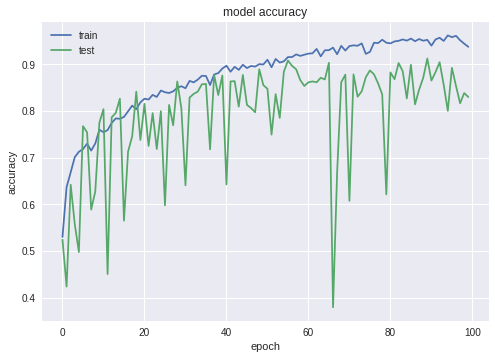

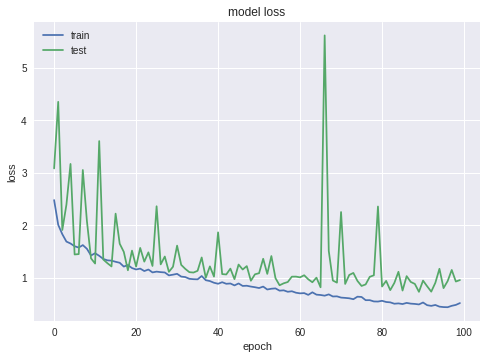

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()